In [1023]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyballmapper as pbm
import geopandas as gpd 
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cm
import kmapper as km
import networkx as nx
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.colors as mcolors


In [1024]:
# load the dataests
# load salary data by workplace
resident = pd.read_excel('/Users/adamsarissky/Desktop/ERP/ASHE_workplace.xlsx', skiprows = 8, skipfooter=7)

# Load Northern Ireland Data
NI_data = pd.read_excel('/Users/adamsarissky/Desktop/ERP/NorthernI_Ireland_Workforce_ASHE.xlsx', sheet_name='Unpivoted')

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [1025]:
# Cleaning data by removing the confidence. 
columns_to_drop = [col for col in resident.columns if 'Unnamed' in str(col)]
resident_cleaned = resident.drop(columns=columns_to_drop)

In [1026]:
# remove first unclera row
resident_cleaned = resident_cleaned.iloc[1:]

In [1027]:
resident_cleaned.head()

,local authority: district / unitary (as of April 2023),2015,2016,2017,2018,2019,2020,2021,2022,2023
1,Hartlepool,26445,26112,25638,25729,26010,28093,28332,30114,32384
2,Middlesbrough,24751,25722,25626,25170,26203,27005,25922,#,31579
3,Redcar and Cleveland,26792,24496,25456,26170,25846,26220,24821,26462,32090
4,Stockton-on-Tees,25345,26884,25258,26540,29049,30531,29026,30643,30508
5,Darlington,26570,27009,25712,26043,27888,28045,29280,#,30928


In [1028]:
# rename columns
resident_cleaned.rename(columns={'local authority: district / unitary (as of April 2023)': 'Local_Authority'}, inplace=True)

In [1029]:
# inspect the data
NI_data.head()

,Statistic Label,Year,Local Government District,Working Pattern,Sex Label,UNIT,VALUE
0,Median Wage,2015,Antrim and Newtownabbey,Full-Time,All Persons,Pounds Sterling (£),27039.0
1,Median Wage,2015,"Armagh City, Banbridge and Craigavon",Full-Time,All Persons,Pounds Sterling (£),22588.0
2,Median Wage,2015,Belfast,Full-Time,All Persons,Pounds Sterling (£),28151.0
3,Median Wage,2015,Causeway Coast and Glens,Full-Time,All Persons,Pounds Sterling (£),20865.0
4,Median Wage,2015,Derry City and Strabane,Full-Time,All Persons,Pounds Sterling (£),23463.0


In [1030]:
# Remove the 'Statistic Label', 'Working Pattern', 'Sex Label', and 'UNIT' columns that we do not care about at all
NI_data = NI_data.drop(columns=['Statistic Label', 'Working Pattern', 'Sex Label', 'UNIT'])

# Rename columns
NI_data = NI_data.rename(columns={
    'Local Government District': 'Local_Authority',
    'VALUE': 'Median_Salary'
})

In [1031]:
# Pivot the data to have a column for each year and salary in it
NI_data = NI_data.pivot(index='Local_Authority', columns='Year', values='Median_Salary').reset_index()

# Rename the columns to remove the multi-level index
NI_data.columns.name = None

# Display the pivoted data
NI_data.head()

,Local_Authority,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Antrim and Newtownabbey,27039.0,27355.0,27090.0,28869.0,27973.0,29242.0,29182.0,29864.0,30627.0
1,Ards and North Down,22814.0,23711.0,24031.0,23410.0,24034.0,25892.0,26882.0,27867.0,29382.0
2,"Armagh City, Banbridge and Craigavon",22588.0,23131.0,24279.0,25257.0,26566.0,28404.0,28393.0,29352.0,32900.0
3,Belfast,28151.0,28896.0,28917.0,29859.0,30346.0,31449.0,31573.0,33490.0,35811.0
4,Causeway Coast and Glens,20865.0,20305.0,NaN,21062.0,22800.0,23424.0,24178.0,26976.0,27027.0


In [1032]:
# pivot longer the data
NI_data = pd.melt(NI_data, id_vars=['Local_Authority'], var_name='Year', value_name='Median_Salary')

In [1033]:
# check the data
NI_data.head()

,Local_Authority,Year,Median_Salary
0,Antrim and Newtownabbey,2015,27039.0
1,Ards and North Down,2015,22814.0
2,"Armagh City, Banbridge and Craigavon",2015,22588.0
3,Belfast,2015,28151.0
4,Causeway Coast and Glens,2015,20865.0


In [1034]:
# check the data
resident_cleaned.head()

,Local_Authority,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,Hartlepool,26445,26112,25638,25729,26010,28093,28332,30114,32384
2,Middlesbrough,24751,25722,25626,25170,26203,27005,25922,#,31579
3,Redcar and Cleveland,26792,24496,25456,26170,25846,26220,24821,26462,32090
4,Stockton-on-Tees,25345,26884,25258,26540,29049,30531,29026,30643,30508
5,Darlington,26570,27009,25712,26043,27888,28045,29280,#,30928


In [1035]:
# pivot long the data
long_resident = pd.melt(resident_cleaned, id_vars=['Local_Authority'], var_name='Year', value_name='Median_Salary')

In [1036]:
# inspect
long_resident.head()

,Local_Authority,Year,Median_Salary
0,Hartlepool,2015,26445
1,Middlesbrough,2015,24751
2,Redcar and Cleveland,2015,26792
3,Stockton-on-Tees,2015,25345
4,Darlington,2015,26570


In [1037]:
NI_data = NI_data[['Local_Authority', 'Year', 'Median_Salary']]

# add ni data to resident data
long_resident = pd.concat([long_resident, NI_data], ignore_index=True)


In [1038]:
# check the data
long_resident.head()

,Local_Authority,Year,Median_Salary
0,Hartlepool,2015,26445
1,Middlesbrough,2015,24751
2,Redcar and Cleveland,2015,26792
3,Stockton-on-Tees,2015,25345
4,Darlington,2015,26570


In [1039]:
# should be numeric to change the #s they  put there to actual missings values
long_resident['Median_Salary'] = pd.to_numeric(long_resident['Median_Salary'], errors='coerce')
long_resident['Year'] = pd.to_numeric(long_resident['Year'])

In [1040]:
# look at missing values in workplace data
long_resident.isnull().sum()

Local_Authority      0
Year                 0
Median_Salary      173
dtype: int64

In [1041]:
# make  a separate df for missnig vals
missing = long_resident[long_resident.isna().any(axis=1)]

In [1042]:
missing

,Local_Authority,Year,Median_Salary
18,Cumberland,2015,NaN
19,Westmorland and Furness,2015,NaN
53,Barnsley,2015,NaN
64,Rutland,2015,NaN
66,North Northamptonshire,2015,NaN
...,...,...,...
3113,Torfaen,2023,NaN
3126,Inverclyde,2023,NaN
3167,Fermanagh and Omagh,2016,NaN
3176,Causeway Coast and Glens,2017,NaN


In [1043]:
# check for LAs that are missing 
local_authority_counts = missing['Local_Authority'].value_counts()

# Filter to include only Local_Authority values with 9 or more instances
filtered_local_authority_counts = local_authority_counts[local_authority_counts >= 9]

In [1044]:
# check. oh the data for city of Lonodn is there. 
filtered_local_authority_counts

Local_Authority
Isles of Scilly    9
Name: count, dtype: int64

In [1045]:
# check those with lots of missing data
filtered_local_authority_counts = local_authority_counts[local_authority_counts >= 7]

In [1046]:
# display
filtered_local_authority_counts

Local_Authority
Isles of Scilly            9
Cumberland                 7
East Suffolk               7
North Northamptonshire     7
West Northamptonshire      7
West Suffolk               7
Westmorland and Furness    7
Name: count, dtype: int64

In [1047]:
filtered_LA = filtered_local_authority_counts.reset_index()
filtered_LA =  pd.DataFrame(filtered_LA)
filtered_LA = filtered_LA['Local_Authority'].tolist()


In [1048]:
# remove the very missing values 
long_resident = long_resident[~long_resident['Local_Authority'].isin(filtered_LA)]

In [1049]:
long_resident.head()

,Local_Authority,Year,Median_Salary
0,Hartlepool,2015,26445.0
1,Middlesbrough,2015,24751.0
2,Redcar and Cleveland,2015,26792.0
3,Stockton-on-Tees,2015,25345.0
4,Darlington,2015,26570.0


In [1050]:
thing = long_resident 

In [1051]:
# Assuming long_resident is already loaded
# Set the Year column as the index and sort it
long_resident.set_index('Year', inplace=True)
long_resident.sort_index(inplace=True)

# Handle missing values in the Median_Salary column
long_resident['Median_Salary'] = long_resident['Median_Salary'].astype(float)

# Separate the data into two sets: one with missing values and one without
data_with_missing = long_resident[long_resident['Median_Salary'].isna()]
data_without_missing = long_resident.dropna(subset=['Median_Salary'])


In [1052]:
data_without_missing.isna().sum()

Local_Authority    0
Median_Salary      0
dtype: int64

In [1053]:
# Split the data without missing values into training and testing sets
train_size = int(len(data_without_missing) * 0.8)
train, test = data_without_missing.iloc[:train_size], data_without_missing.iloc[train_size:]

# Check for and remove duplicate indices
train = train[~train.index.duplicated(keep='first')]
test = test[~test.index.duplicated(keep='first')]

# Train ARIMA model on the training set
model = ARIMA(train['Median_Salary'], order=(1, 1, 1))
model_fit = model.fit()

# Predict the values for the test set
test['Median_Salary_Predicted'] = model_fit.predict(start=train.index[-1], end=test.index[-1], dynamic=False)


/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. U

In [1054]:
test.isna().sum()   

Local_Authority            0
Median_Salary              0
Median_Salary_Predicted    0
dtype: int64

In [1055]:

# Calculate the RMSE for the test set predictions
rmse = sqrt(mean_squared_error(test['Median_Salary'], test['Median_Salary_Predicted']))
print(f'RMSE: {rmse}')

# Calculate the MAPE for the test set predictions
mape = np.mean(np.abs((test['Median_Salary'] - test['Median_Salary_Predicted']) / test['Median_Salary'])) * 100
print(f'MAPE: {mape}%')

# Predict the missing values using the trained model
# Ensure the start and end indices are correctly set
start_index = data_without_missing.index[-1] + 1
end_index = long_resident.index[-1]

# Ensure start_index is before end_index
if start_index <= end_index:
    data_with_missing['Median_Salary_Predicted'] = model_fit.predict(start=start_index, end=end_index)
    # Fill the missing values in the original dataset with the predicted values
    long_resident.loc[data_with_missing.index, 'Median_Salary'] = data_with_missing['Median_Salary_Predicted']

# Drop the prediction column
long_resident.drop(columns=['Median_Salary_Predicted'], inplace=True, errors='ignore')

# Display the DataFrame
long_resident.head()

RMSE: 2510.1596527352494
MAPE: 6.117825157743559%


,Local_Authority,Median_Salary
Year,,
2015,Hartlepool,26445.0
2015,Oxford,31165.0
2015,Cherwell,28580.0
2015,Tunbridge Wells,27333.0
2015,Tonbridge and Malling,28492.0


In [1056]:
long_resident = thing

In [1057]:
long_resident.head()

,Local_Authority,Median_Salary
Year,,
2015,Hartlepool,26445.0
2015,Oxford,31165.0
2015,Cherwell,28580.0
2015,Tunbridge Wells,27333.0
2015,Tonbridge and Malling,28492.0


In [1058]:
filtered_local_authority_counts

Local_Authority
Isles of Scilly            9
Cumberland                 7
East Suffolk               7
North Northamptonshire     7
West Northamptonshire      7
West Suffolk               7
Westmorland and Furness    7
Name: count, dtype: int64

In [1059]:
# missing data by year

long_resident.groupby('Year')['Median_Salary'].apply(lambda x: x.isnull().sum())

Year
2015    14
2016    16
2017    11
2018    16
2019     9
2020    11
2021     5
2022    20
2023    20
Name: Median_Salary, dtype: int64

In [1060]:
# Load CPIH data from ONS

data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'CPIH index': [100, 101, 103.6, 106.0, 107.8, 108.9, 111.6, 120.5, 128.6]
}

# Create the CPIH DataFrame
CPIH = pd.DataFrame(data)

In [1061]:
# inspect
CPIH

,Year,CPIH index
0,2015,100.0
1,2016,101.0
2,2017,103.6
3,2018,106.0
4,2019,107.8
5,2020,108.9
6,2021,111.6
7,2022,120.5
8,2023,128.6


In [1062]:
# get cpih data to dataset
long_resident_CPIH = pd.merge(long_resident, CPIH, on='Year', how='left')

In [1063]:
# inspect 
long_resident_CPIH.head()

,Year,Local_Authority,Median_Salary,CPIH index
0,2015,Hartlepool,26445.0,100.0
1,2015,Oxford,31165.0,100.0
2,2015,Cherwell,28580.0,100.0
3,2015,Tunbridge Wells,27333.0,100.0
4,2015,Tonbridge and Malling,28492.0,100.0


In [1064]:
# calculate adjusted data 
long_resident_CPIH['adjusted_salary'] = (long_resident_CPIH['Median_Salary'] / (long_resident_CPIH['CPIH index'] / 100)).round(0)

In [1065]:
# display
long_resident_CPIH.head()

,Year,Local_Authority,Median_Salary,CPIH index,adjusted_salary
0,2015,Hartlepool,26445.0,100.0,26445.0
1,2015,Oxford,31165.0,100.0,31165.0
2,2015,Cherwell,28580.0,100.0,28580.0
3,2015,Tunbridge Wells,27333.0,100.0,27333.0
4,2015,Tonbridge and Malling,28492.0,100.0,28492.0


In [1066]:
# inspect
long_resident.groupby('Year')['Median_Salary'].median().reset_index()

,Year,Median_Salary
0,2015,26081.0
1,2016,26707.0
2,2017,27032.0
3,2018,27787.5
4,2019,28732.0
5,2020,29392.0
6,2021,29590.0
7,2022,31228.5
8,2023,33104.5


calculations for LAs at certain levels - not present in the analysis but still informed decisions

In [1067]:
#  Filter for 2020 and 2024
salaries_2020 = long_resident_CPIH[long_resident_CPIH['Year'] == 2020][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2020'})
salaries_2023 = long_resident_CPIH[long_resident_CPIH['Year'] == 2023][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2023'})

# Step 2: Merge the DataFrames on LA
merged_salaries = salaries_2020.merge(salaries_2023, on='Local_Authority')

# Step 3: Compare adjusted_salary for 2024 against 2020 for each LA
merged_salaries['is_higher_or_equal_2023'] = merged_salaries['adjusted_salary_2023'] >= merged_salaries['adjusted_salary_2020']

# Step 4: Count the LAs that meet the condition
number_of_LAs_meeting_condition = merged_salaries['is_higher_or_equal_2023'].sum()

print(f"Number of local authorities with their 2023 salaries at the level of or higher than in 2020: {number_of_LAs_meeting_condition}")

Number of local authorities with their 2023 salaries at the level of or higher than in 2020: 58


In [1068]:
# Step 1: Filter for 2020 and 2024
salaries_2022 = long_resident_CPIH[long_resident_CPIH['Year'] == 2022][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2022'})

# Step 2: Merge the DataFrames on LA
merged_salaries = merged_salaries.merge(salaries_2022, on='Local_Authority')

# Step 3: Compare adjusted_salary for 2024 against 2020 for each LA
merged_salaries['is_higher_or_equal_2022'] = merged_salaries['adjusted_salary_2022'] >= merged_salaries['adjusted_salary_2020']

# Step 4: Count the LAs that meet the condition
number_of_LAs_meeting_condition = merged_salaries['is_higher_or_equal_2022'].sum()

print(f"Number of local authorities with their 2022 salaries at the level of or higher than in 2020: {number_of_LAs_meeting_condition}")

Number of local authorities with their 2022 salaries at the level of or higher than in 2020: 63


In [1069]:
# Step 1: Filter for 2020 and 2024
salaries_2021 = long_resident_CPIH[long_resident_CPIH['Year'] == 2021][['Local_Authority', 'adjusted_salary']].rename(columns={'adjusted_salary': 'adjusted_salary_2021'})

# Step 2: Merge the DataFrames on LA
merged_salaries = merged_salaries.merge(salaries_2021, on='Local_Authority')

# Step 3: Compare adjusted_salary for 2024 against 2020 for each LA
merged_salaries['is_higher_or_equal_2021'] = merged_salaries['adjusted_salary_2021'] >= merged_salaries['adjusted_salary_2020']

# Step 4: Count the LAs that meet the condition
number_of_LAs_meeting_condition = merged_salaries['is_higher_or_equal_2021'].sum()

print(f"Number of local authorities with their 2021 salaries at the level of or higher than in 2020: {number_of_LAs_meeting_condition}")

Number of local authorities with their 2021 salaries at the level of or higher than in 2020: 92


In [1070]:
merged_salaries.head()

,Local_Authority,adjusted_salary_2020,adjusted_salary_2023,is_higher_or_equal_2023,adjusted_salary_2022,is_higher_or_equal_2022,adjusted_salary_2021,is_higher_or_equal_2021
0,Adur,25111.0,25666.0,True,22190.0,False,23039.0,False
1,Surrey Heath,35611.0,NaN,False,32211.0,False,34428.0,False
2,Woking,35935.0,28928.0,False,32192.0,False,NaN,False
3,Waverley,26736.0,25900.0,False,25627.0,False,25788.0,False
4,Tandridge,28968.0,31395.0,True,27705.0,False,26828.0,False


In [1071]:
# forward fill data to see if it is missing values. 
salary_data = long_resident_CPIH
salary_data['Median_Salary'] = salary_data['Median_Salary'].ffill()
salary_data['adjusted_salary'] = salary_data['adjusted_salary'].ffill()



In [1072]:
salary_data.isnull().sum()

Year               0
Local_Authority    0
Median_Salary      0
CPIH index         0
adjusted_salary    0
dtype: int64

In [1073]:
merged_salaries.isnull().sum()

Local_Authority             0
adjusted_salary_2020       11
adjusted_salary_2023       20
is_higher_or_equal_2023     0
adjusted_salary_2022       20
is_higher_or_equal_2022     0
adjusted_salary_2021        5
is_higher_or_equal_2021     0
dtype: int64

In [1074]:
salaries_2020.head()

,Local_Authority,adjusted_salary_2020
1770,Adur,25111.0
1771,Surrey Heath,35611.0
1772,Woking,35935.0
1773,Waverley,26736.0
1774,Tandridge,28968.0


In [1075]:
merged_salaries.head()

,Local_Authority,adjusted_salary_2020,adjusted_salary_2023,is_higher_or_equal_2023,adjusted_salary_2022,is_higher_or_equal_2022,adjusted_salary_2021,is_higher_or_equal_2021
0,Adur,25111.0,25666.0,True,22190.0,False,23039.0,False
1,Surrey Heath,35611.0,NaN,False,32211.0,False,34428.0,False
2,Woking,35935.0,28928.0,False,32192.0,False,NaN,False
3,Waverley,26736.0,25900.0,False,25627.0,False,25788.0,False
4,Tandridge,28968.0,31395.0,True,27705.0,False,26828.0,False


In [1076]:
merged = shapefile.set_index('LAD24NM').join(merged_salaries.set_index('Local_Authority'))


In [1077]:
merged_salaries['resilience_indicator'] = merged_salaries[['is_higher_or_equal_2021', 'is_higher_or_equal_2022', 'is_higher_or_equal_2023']].sum(axis=1)

In [1078]:
merged_salaries['resilience_indicator'].value_counts()

resilience_indicator
0    210
1     88
2     43
3     13
Name: count, dtype: int64

In [1079]:
merged_resilience = shapefile.set_index('LAD24NM').join(merged_salaries.set_index('Local_Authority'))


In [1080]:
long_data = merged_salaries.replace({False: 0, True: 1})

/var/folders/kh/kvrs5sp15tx0d3k647zd9b540000gn/T/ipykernel_35160/3174507064.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [1081]:
long_data.head()

,Local_Authority,adjusted_salary_2020,adjusted_salary_2023,is_higher_or_equal_2023,adjusted_salary_2022,is_higher_or_equal_2022,adjusted_salary_2021,is_higher_or_equal_2021,resilience_indicator
0,Adur,25111.0,25666.0,1,22190.0,0,23039.0,0,1
1,Surrey Heath,35611.0,NaN,0,32211.0,0,34428.0,0,0
2,Woking,35935.0,28928.0,0,32192.0,0,NaN,0,0
3,Waverley,26736.0,25900.0,0,25627.0,0,25788.0,0,0
4,Tandridge,28968.0,31395.0,1,27705.0,0,26828.0,0,1


In [1082]:
long_data = long_data.drop(columns=['resilience_indicator'])

In [1083]:
long_data = pd.melt(long_data, id_vars=['Local_Authority'], var_name='year', value_name='recovered')


In [1084]:
long_data['year'] = long_data['year'].str.extract(r'(\d{4})')

In [1085]:
resilience_indicator = merged_salaries[['Local_Authority', 'resilience_indicator']]

In [1086]:
resilience_indicator.head()

,Local_Authority,resilience_indicator
0,Adur,1
1,Surrey Heath,0
2,Woking,0
3,Waverley,0
4,Tandridge,1


In [1087]:
long_resident_CPIH.head()

,Year,Local_Authority,Median_Salary,CPIH index,adjusted_salary
0,2015,Hartlepool,26445.0,100.0,26445.0
1,2015,Oxford,31165.0,100.0,31165.0
2,2015,Cherwell,28580.0,100.0,28580.0
3,2015,Tunbridge Wells,27333.0,100.0,27333.0
4,2015,Tonbridge and Malling,28492.0,100.0,28492.0


In [1088]:
data = long_resident_CPIH

In [1089]:
data.head()

,Year,Local_Authority,Median_Salary,CPIH index,adjusted_salary
0,2015,Hartlepool,26445.0,100.0,26445.0
1,2015,Oxford,31165.0,100.0,31165.0
2,2015,Cherwell,28580.0,100.0,28580.0
3,2015,Tunbridge Wells,27333.0,100.0,27333.0
4,2015,Tonbridge and Malling,28492.0,100.0,28492.0


In [1090]:
TDA_data = data.pivot(index='Local_Authority', columns='Year', values='adjusted_salary')
TDA_data.columns = [f'salaries_{col}' for col in TDA_data.columns]
TDA_data.reset_index(inplace=True)


In [1091]:
TDA_data = TDA_data.merge(resilience_indicator, on='Local_Authority')

In [1092]:
TDA_data.head()

,Local_Authority,salaries_2015,salaries_2016,salaries_2017,salaries_2018,salaries_2019,salaries_2020,salaries_2021,salaries_2022,salaries_2023,resilience_indicator
0,Aberdeen City,33396.0,32096.0,29484.0,30415.0,30533.0,32295.0,29297.0,28734.0,29047.0,0
1,Aberdeenshire,27666.0,27598.0,26286.0,27497.0,27818.0,28682.0,25854.0,26738.0,26267.0,0
2,Adur,24061.0,24031.0,24975.0,24364.0,25219.0,25111.0,23039.0,22190.0,25666.0,1
3,Amber Valley,26384.0,27450.0,28649.0,27333.0,27301.0,26974.0,27797.0,24287.0,25931.0,1
4,Angus,22522.0,24286.0,23713.0,25217.0,24836.0,26188.0,22972.0,24416.0,27233.0,1


In [1093]:
merged_salaries.head()

,Local_Authority,adjusted_salary_2020,adjusted_salary_2023,is_higher_or_equal_2023,adjusted_salary_2022,is_higher_or_equal_2022,adjusted_salary_2021,is_higher_or_equal_2021,resilience_indicator
0,Adur,25111.0,25666.0,True,22190.0,False,23039.0,False,1
1,Surrey Heath,35611.0,NaN,False,32211.0,False,34428.0,False,0
2,Woking,35935.0,28928.0,False,32192.0,False,NaN,False,0
3,Waverley,26736.0,25900.0,False,25627.0,False,25788.0,False,0
4,Tandridge,28968.0,31395.0,True,27705.0,False,26828.0,False,1


In [1094]:
merged_salaries['is_higher_or_equal_2021'] = merged_salaries['is_higher_or_equal_2021'].astype(int)
merged_salaries['is_higher_or_equal_2022'] = merged_salaries['is_higher_or_equal_2022'].astype(int)
merged_salaries['is_higher_or_equal_2023'] = merged_salaries['is_higher_or_equal_2023'].astype(int)
merged_salaries.drop(columns=['resilience_indicator'], inplace=True)


In [1095]:
TDA_data = TDA_data.merge(merged_salaries, on='Local_Authority')

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



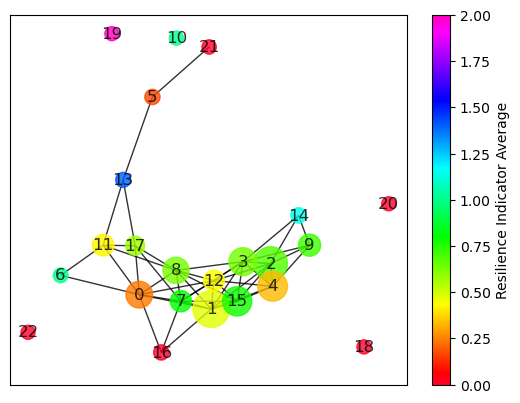

In [1096]:
bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['resilience_indicator'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='resilience_indicator', color_palette=hsvp, colorbar=True, colorbar_label="Resilience Indicator Average",
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))

plt.grid(False)  # This removes gridlines

# Show the plot
plt.show()

In [1097]:
pb1 = bm1.points_and_balls()
TDA_data['point'] = TDA_data.index
TDA_data = TDA_data.merge(pb1, on='point')

In [1098]:
TDA_data[TDA_data['ball'] == 21]['Local_Authority'].unique()

array(['Islington', 'Westminster'], dtype=object)

In [1099]:
TDA_data[TDA_data['ball'] == 5]['Local_Authority'].unique()

array(['Bracknell Forest', 'Camden', 'Hammersmith and Fulham',
       'Islington', 'Runnymede', 'Southwark'], dtype=object)

In [1100]:
TDA_data[TDA_data['ball'] == 13]['Local_Authority'].unique()

array(['Camden', 'Guildford', 'Hackney', 'Mole Valley',
       'Vale of White Horse'], dtype=object)

In [1101]:
TDA_data[TDA_data['ball'] == 19]['Local_Authority']

862    Three Rivers
Name: Local_Authority, dtype: object

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

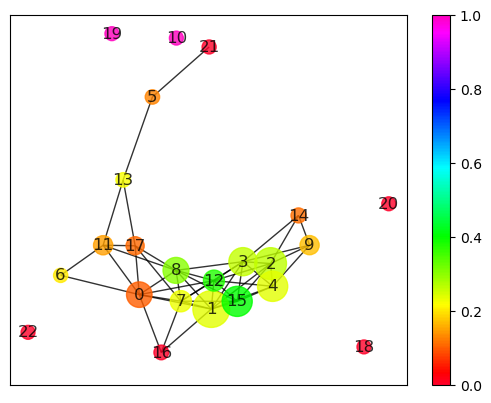

In [1102]:
bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2021'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2021', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

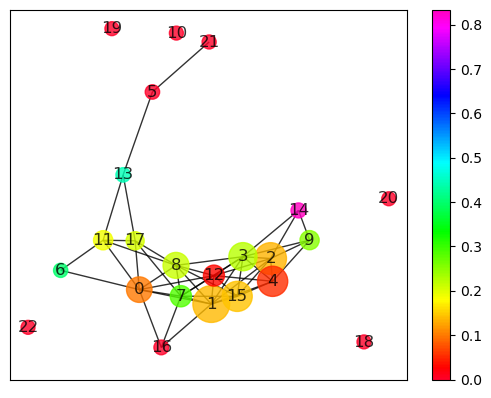

In [1103]:
bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2022'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2022', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

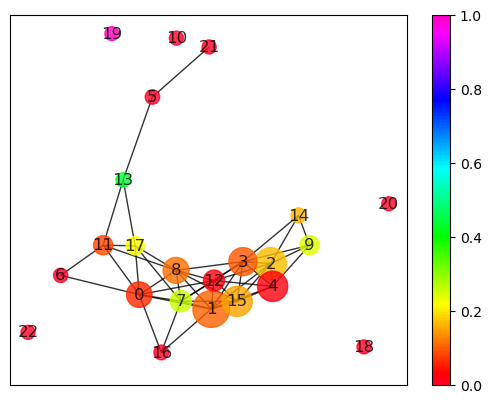

In [1104]:
bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2023'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2023', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



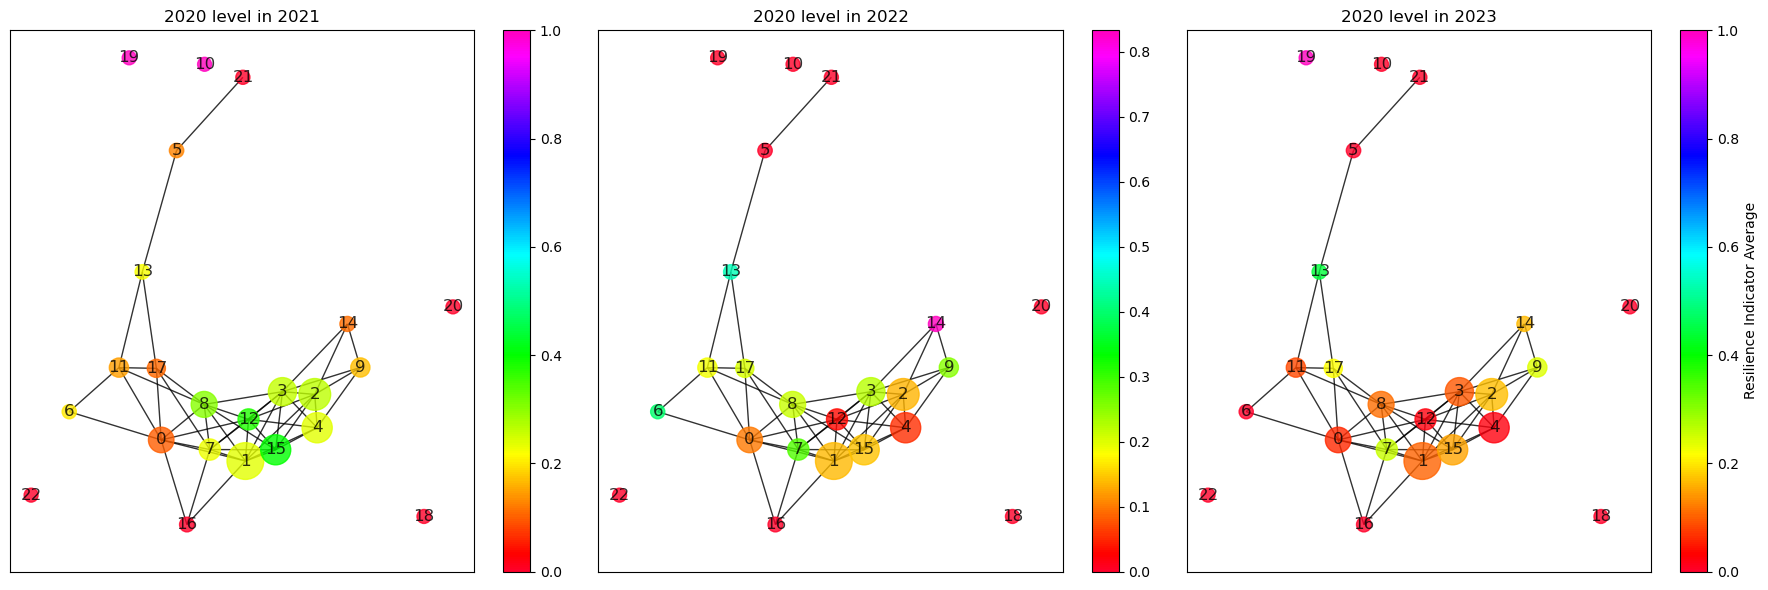

In [1105]:
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
bmx1 = TDA_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2021'])
bm1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2021', color_palette=hsvp, colorbar=True, 
                  pos=nx.spring_layout(bm1.Graph, k=0.6, seed=55), ax=axes[0])
axes[0].set_title('2020 level in 2021')
axes[0].grid(False)  # This removes gridlines from the first subplot


# Plot 2
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2022'])
bm1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2022', color_palette=hsvp, colorbar=True, 
                  pos=nx.spring_layout(bm1.Graph, k=0.6, seed=55), ax=axes[1])
axes[1].set_title('2020 level in 2022')
axes[1].grid(False)  # This removes gridlines from the first subplot


# Plot 3
cdf = pd.DataFrame(TDA_data['is_higher_or_equal_2023'])
bm1 = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
bm1.draw_networkx(coloring_variable='is_higher_or_equal_2023', color_palette=hsvp, colorbar=True, colorbar_label="Resilience Indicator Average", 
                  pos=nx.spring_layout(bm1.Graph, k=0.6, seed=55), ax=axes[2])
axes[2].set_title('2020 level in 2023')

# Adjust layout
plt.grid(False)  # This removes gridlines
plt.tight_layout()
plt.show()

In [1106]:
urban_rural = pd.read_excel('/Users/adamsarissky/Desktop/ERP/urban_rural.xlsx', sheet_name=2, skiprows=1, usecols=['Local authority code', 'Local authority name', 'Summary_Classification'])

In [1107]:
urban_rural.head()

,Local authority code,Local authority name,Summary_Classification
0,S12000033,Aberdeen City,Other City
1,S12000034,Aberdeenshire,Village or smaller
2,E07000223,Adur,Medium Town
3,E07000026,Allerdale,Village or smaller
4,E07000032,Amber Valley,Small Town


In [1108]:
urban_rural = pd.get_dummies(urban_rural, columns=['Summary_Classification'], prefix='SC', dtype=int)


In [1109]:
urban_rural.rename(columns={'Local authority name': 'Local_Authority'}, inplace=True)


In [1110]:
some_data = data.pivot(index='Local_Authority', columns='Year', values='adjusted_salary')
some_data.columns = [f'salaries_{col}' for col in some_data.columns]
some_data.reset_index(inplace=True)
urban_data = some_data.merge(urban_rural, on='Local_Authority')

In [1111]:
urban_data.head()

,Local_Authority,salaries_2015,salaries_2016,salaries_2017,salaries_2018,salaries_2019,salaries_2020,salaries_2021,salaries_2022,salaries_2023,Local authority code,SC_Core City,SC_Large Town,SC_Medium Town,SC_Other City,SC_Small Town,SC_Village or smaller
0,Aberdeen City,33396.0,32096.0,29484.0,30415.0,30533.0,32295.0,29297.0,28734.0,29047.0,S12000033,0,0,0,1,0,0
1,Aberdeenshire,27666.0,27598.0,26286.0,27497.0,27818.0,28682.0,25854.0,26738.0,26267.0,S12000034,0,0,0,0,0,1
2,Adur,24061.0,24031.0,24975.0,24364.0,25219.0,25111.0,23039.0,22190.0,25666.0,E07000223,0,0,1,0,0,0
3,Amber Valley,26384.0,27450.0,28649.0,27333.0,27301.0,26974.0,27797.0,24287.0,25931.0,E07000032,0,0,0,0,1,0
4,Angus,22522.0,24286.0,23713.0,25217.0,24836.0,26188.0,22972.0,24416.0,27233.0,S12000041,0,0,0,0,1,0


/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



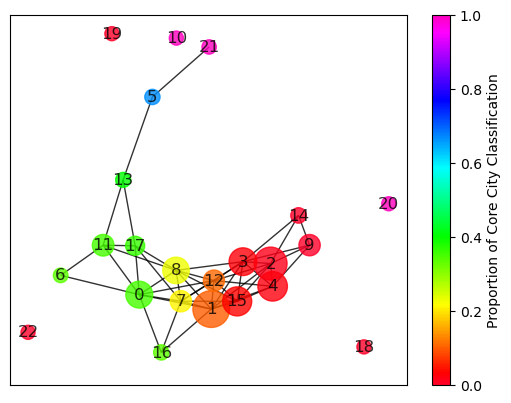

In [1112]:
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Core City'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Core City', color_palette=hsvp, colorbar=True, colorbar_label="Proportion of Core City Classification",
pos=nx.spring_layout(bm1.Graph, k = 0.6, seed=55))
plt.grid(False)  # This removes gridlines


/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



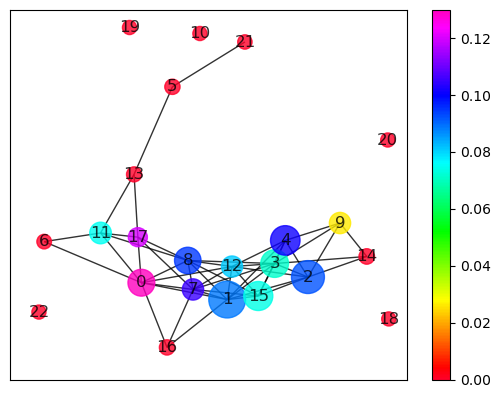

In [1113]:
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Other City'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Other City', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))
plt.grid(False) 

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

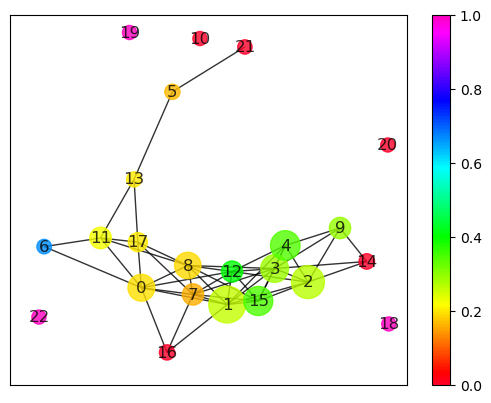

In [1114]:
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Large Town'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Large Town', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

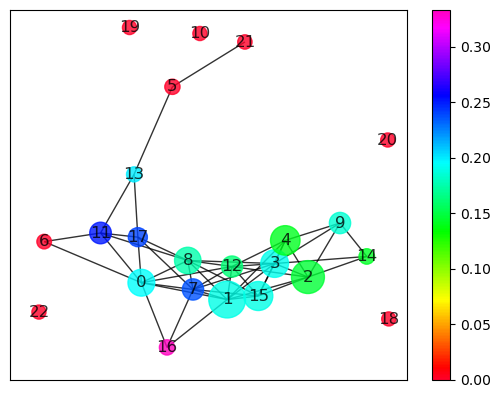

In [1115]:
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Medium Town'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Medium Town', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

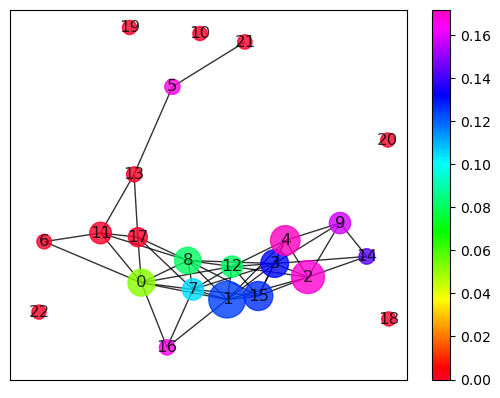

In [1116]:
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Small Town'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Small Town', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



<Axes: >

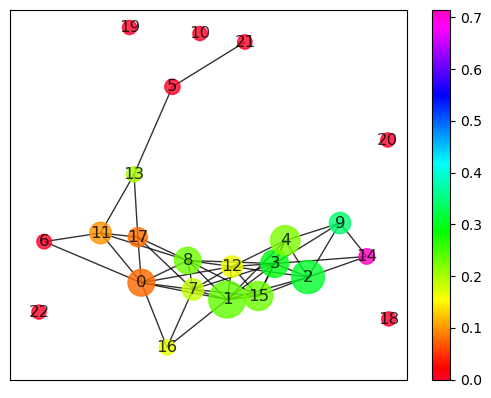

In [1117]:
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf = pd.DataFrame(urban_data['SC_Village or smaller'])
bm1=pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf)
hsvp = cm.get_cmap("gist_rainbow")
bm1.draw_networkx(coloring_variable='SC_Village or smaller', color_palette=hsvp, colorbar=True, 
pos=nx.spring_layout(bm1.Graph, k = 0.7, seed=55))

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering

/Users/adamsarissky/anaconda3/envs/py310/lib/python3.10/site-packages/pyballmapper/ballmapper.py:292: UserWarning:

Warning........... order is not a list or numpy array, using default ordering



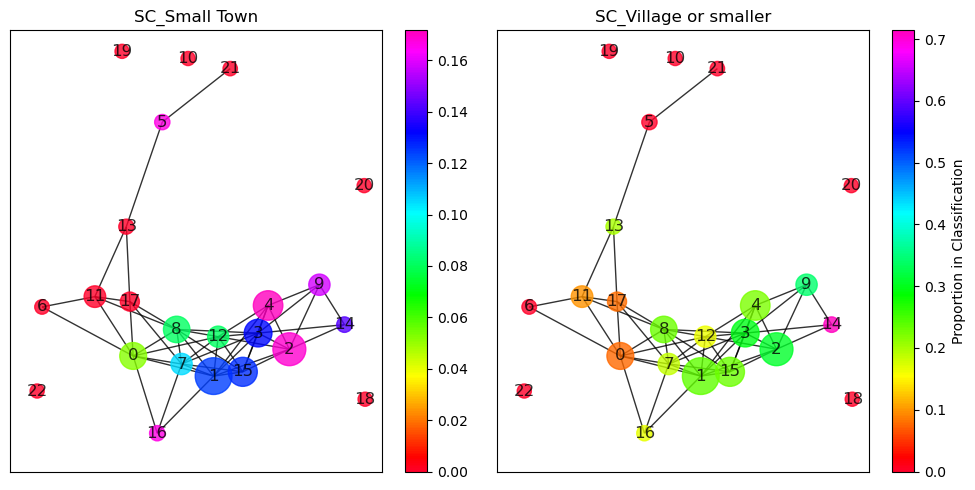

In [1118]:
# Create a figure with 1 row and 2 columns for the two plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize for appropriate sizing

# Plot 1: SC_Small Town
bmx1 = urban_data[['salaries_2020', 'salaries_2021', 'salaries_2022', 'salaries_2023']]
cdf_small_town = pd.DataFrame(urban_data['SC_Small Town'])
bm_small_town = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_small_town)
hsvp = cm.get_cmap("gist_rainbow")

# Draw network for 'SC_Small Town'
bm_small_town.draw_networkx(coloring_variable='SC_Small Town', color_palette=hsvp, colorbar=True, 
                            pos=nx.spring_layout(bm_small_town.Graph, k=0.7, seed=55), ax=axes[0])
axes[0].set_title('SC_Small Town')
axes[0].grid(False)

# Plot 2: SC_Village or smaller
cdf_village = pd.DataFrame(urban_data['SC_Village or smaller'])
bm_village = pbm.BallMapper(X=bmx1, eps=5000, coloring_df=cdf_village)

# Draw network for 'SC_Village or smaller'
bm_village.draw_networkx(coloring_variable='SC_Village or smaller', color_palette=hsvp, colorbar=True, colorbar_label="Proportion in Classification",
                         pos=nx.spring_layout(bm_village.Graph, k=0.7, seed=55), ax=axes[1])
axes[1].set_title('SC_Village or smaller')
axes[1].grid(False)

# Display the combined figure
plt.tight_layout()
plt.show()